In [1]:
import numpy as np
import xarray as xr
import sys
import glob
import netCDF4 as nc
import os
import sys
import h5py
import scipy.io
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import cartopy.feature as cfeature
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
import pandas
from datetime import timedelta
from datetime import date

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

from functions_ecco_NEW import shift_longitude, remove_text_after_second_underscore, calculate_data2plot, \
plot_map_from_gridded, create_gridded_from_scattered, get_colorbar_extend, \
plot_map_from_gridded_4contributor, \
map_contributor_positive_negative, map_first_or_third_contributor, map_second_contributor

# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')


# Inputs

### What we have so far (February 2024):
### OISST MONTHLY only (keep in mind that the name of the plots has daily in it - needs to be fixed in the future):
    - 1993-2016 and 2004-2016
##### How to run it:
    - lev_or_int = 'oisst'
    - dataset_tag = 'oisst_v2'
    - daily_monthly_plot_tag = 'daily'
    - ecco_monthly_tag_field = 'heat'
    - ecco_monthly_tag = False 
    - ecco_daily_tag = True 
    - test_peaks_tag = False
    - delta_time_tag = '1tstep'
    
### ECCO MONTHLY - HEAT:
    - 1993-2016 and 2004-2016
##### How to run it:
    - lev_or_int = 'zlev01'
    - dataset_tag = 'ECCOv4r4_heat'
    - daily_monthly_plot_tag = 'monthly'
    - ecco_monthly_tag_field = 'heat'
    - ecco_monthly_tag = True 
    - ecco_daily_tag = False  
    - test_peaks_tag = False
    - delta_time_tag = '1tstep'
    
### ECCO monthly OHC: 
    - 1993-2016 and 2004-2016:
##### How to run it:
    - lev_or_int = zlev01
    - dataset_tag = 'ECCOv4r4_heat'
    - ecco_monthly_tag_field = 'ohc_to50m'
    - daily_monthly_plot_tag = monthly
    - ecco_monthly_tag = True
    - ecco_daily_tag = False
    - delta_time_tag = '1tstep'   

### ECCO daily: 
    - 1992-2018 and 2004-2016:
    
##### How to run it:
    - lev_or_int = zlev00 or zlev05 or zlev09
    - dataset_tag = 'ECCOv4r4_heat'
    - ecco_monthly_tag_field = 'heat'
    - daily_monthly_plot_tag = daily
    - ecco_monthly_tag = False
    - ecco_daily_tag = True
    - delta_time_tag = '5tstep' 
    
### Argo: 
    - 2004-2016:
    
##### How to run it:
    - lev_or_int = argo
    - dataset_tag = 'argo_ohc15_50'
    - ecco_monthly_tag_field = 'heat'
    - daily_monthly_plot_tag = daily
    - ecco_monthly_tag = False
    - ecco_daily_tag = True
    - delta_time_tag = '5tstep'  

In [2]:
def get_dict_4_case_of_interest(tag_case):
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 30+days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY zlev00 1992-2018 30+days plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 2004-2016 5-30days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 2004-2016 30+days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY zlev00 2004-2016 5-30days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
    
    if tag_case == 'ECCO DAILY zlev00 2004-2016 30+days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2017, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})
# MONTHLY
    if tag_case == 'ECCO MONTHLY OHC k0-k5 1993-2016 plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'ohc_to50m', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO MONTHLY OHC k0-k5 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'ohc_to50m', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO MONTHLY zlev01 1993-2016 plot years 1993-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO MONTHLY zlev01 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev01', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})

    if tag_case == 'ARGO MONTHLY OHC 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'argo_ohc15_50', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'argo', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'OISST MONTHLY 2004-2016 plot years 2004-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'OISST MONTHLY 1993-2016 plot years 1993-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'monthly', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'1tsteps', \
                "MHW_duration_min_threshold":1, "MHW_duration_max_threshold":np.inf})    

    
    
    
# 5+ days - 1993-2016

    if tag_case == 'ECCO DAILY OHC k0-k5 1992-2018 5+days plot years 1992-2018':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":1992, "year_end_in_filename":2018, \
                "year_start_inside_file":1992, "year_end_inside_file":2017, \
                "year_start_4plot":1992, "year_end_4plot":2018, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":np.inf})

    if tag_case == 'ECCO DAILY zlev00 2004-2016 5+days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'zlev00', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'ECCO DAILY OHC k0-k5 2004-2016 5+days plot years 2004-2016':
        return({"dataset_tag":'ECCOv4r4_heat', 
                "year_start_in_filename":2004, "year_end_in_filename":2016, \
                "year_start_inside_file":2004, "year_end_inside_file":2016, \
                "year_start_4plot":2004, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'ohc_k0_k5', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":np.inf})
    
    if tag_case == 'OISST DAILY k0 1993-2016 5+days plot years 1993-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":np.inf})
     
# OISST 5-30

    if tag_case == 'OISST DAILY k0 1993-2016 5-30days plot years 1993-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":5, "MHW_duration_max_threshold":30})
# OISST 30+
    if tag_case == 'OISST DAILY k0 1993-2016 30+days plot years 1993-2016':
        return({"dataset_tag":'oisst_v2', 
                "year_start_in_filename":1993, "year_end_in_filename":2016, \
                "year_start_inside_file":1993, "year_end_inside_file":2016, \
                "year_start_4plot":1993, "year_end_4plot":2016, \
                "extra_var_tag":'temp_', "lev_or_int":'oisst', \
                "daily_monthly_plot_tag":'daily', "ecco_monthly_tag_field":'heat', \
                "delta_time_tag":'5tsteps', \
                "MHW_duration_min_threshold":30, "MHW_duration_max_threshold":np.inf})    

In [3]:
# ECCO daily ohc 1992-2018 (5-30, 30+) - NOTrun
# ECCO daily ohc 1993-2016 (5-30, 30+) - NOTrun
# ECCO daily ohc 2004-2016 (5-30, 30+) - NOTrun

# ECCO daily zlev 0 1992-2018 (5-30, 30+) - NOTrun
# ECCO daily zlev 0 1993-2016 (5-30, 30+) - NOTrun
# ECCO daily zlev 0 2004-2016 (5-30, 30+) - NOTrun

# Argo monthly ohc 2004-2016 (1+) - NOTrun

# ECCO monthly zlev 0 2004-2016 (1+) - NOTrun
# ECCO monthly zlev 0 1993-2016 (1+) - NOTrun
# ECCO monthly OHC k0-k5 1993-2016 (1+) - NOTrun
# ECCO monthly OHC k0-k5 2004-2016 (1+) - NOTrun

# OISST monthly 2004-2016 (1+) - NOTrun
# OISST monthly 1993-2016 (1+) - NOTrun


# ECCO daily ohc 1992-2018 (5+) - in progress


In [226]:
# 1992-2018 ECCO daily k0-k5 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1992-2018')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1992-2018')

# 1992-2018 ECCO daily zlev00 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1992-2018')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 30+days plot years 1992-2018')

# 1993-2016 ECCO daily k0-k5 (5-30, 30+)
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 5-30days plot years 1993-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 30+days plot years 1993-2016')

# 1993-2016 ECCO daily zlev00 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 5-30days plot years 1993-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 1992-2018 30+days plot years 1993-2016')

# 2004-2016 ECCO daily k0-k5 (5-30, 30+) - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 2004-2016 5-30days plot years 2004-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 2004-2016 30+days plot years 2004-2016')

# 2004-2016 ECCO daily zlev00 (5-30, 30+) - in progress
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 2004-2016 5-30days plot years 2004-2016')
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 2004-2016 30+days plot years 2004-2016')

# 1993-2016 ECCO monthly k0-k5 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY OHC k0-k5 1993-2016 plot years 1993-2016')

# 2004-2016 ECCO monthly k0-k5 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY OHC k0-k5 2004-2016 plot years 2004-2016')

# 1993-2016 ECCO monthly zlev00 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY zlev01 1993-2016 plot years 1993-2016')

# 2004-2016 ECCO monthly zlev00 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO MONTHLY zlev01 2004-2016 plot years 2004-2016')

# 2004-2016 Argo monthly k0-k5 - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'ARGO MONTHLY OHC 2004-2016 plot years 2004-2016')

# 2004-2016 OISST monthly SST - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'OISST MONTHLY 2004-2016 plot years 2004-2016')

# 1993-2016 OISST monthly SST - DONE
# case_sel = get_dict_4_case_of_interest(tag_case = 'OISST MONTHLY 1993-2016 plot years 1993-2016')




In [4]:
# 5 DAYS + (JUNE 2024)

# 2004-2016 ECCO daily k0 (5+) - DONE JUNE 2024
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY zlev00 2004-2016 5+days plot years 2004-2016')

# 2004-2016 ECCO daily k0-k5 (5+) - DONE JUNE 2024
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 2004-2016 5+days plot years 2004-2016')

# 1992-2018 ECCO daily k0-k5 (5+) - 
# case_sel = get_dict_4_case_of_interest(tag_case = 'ECCO DAILY OHC k0-k5 1992-2018 5+days plot years 1992-2018')

# 2004-2016 OISST daily k0 (5+)
# case_sel = get_dict_4_case_of_interest(tag_case = 'OISST DAILY k0 1993-2016 5+days plot years 1993-2016')

# 1993-2016 OISST daily k0 (5-30)
# case_sel = get_dict_4_case_of_interest(tag_case = 'OISST DAILY k0 1993-2016 5-30days plot years 1993-2016')

# 1993-2016 OISST daily k0 (30+)
case_sel = get_dict_4_case_of_interest(tag_case = 'OISST DAILY k0 1993-2016 30+days plot years 1993-2016')

In [5]:
for ivar in case_sel.keys():
    globals()[ivar] = case_sel[ivar]
    

In [6]:
year_start_in_filename = year_start_in_filename
year_end_in_filename = year_end_in_filename
year_start_inside_file = year_start_inside_file
year_end_inside_file = year_end_inside_file
year_start_4plot = year_start_4plot

dataset_tag = dataset_tag
extra_var_tag = extra_var_tag

lev_or_int = lev_or_int

daily_monthly_plot_tag = daily_monthly_plot_tag
ecco_monthly_tag_field = ecco_monthly_tag_field

grid_and_save_fields_2plot = True

delta_time_tag = delta_time_tag
MHW_duration_min_threshold = MHW_duration_min_threshold
MHW_duration_max_threshold = MHW_duration_max_threshold

# path_blanca_outputs_prefix = '/Users/jacoposala/Downloads/Blanca_Outputs/'
path_blanca_outputs_prefix = '/Users/jacoposala/Downloads/Blanca_Outputs_June/'
path_blanca_outputs_prefix = '/Users/jacoposala/Desktop/'


path_blanca_outputs_suffix = '/output/figures/'
load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + daily_monthly_plot_tag + '_' + extra_var_tag + lev_or_int + '_' + str(year_start_in_filename) + '_' + str(year_end_in_filename) + path_blanca_outputs_suffix

ECCO_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/'
save_dir = join(ECCO_dir,'outputs')
path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/data/outputs/nc_files_zlev_or_zint/'
save_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/summary_maps/' + lev_or_int + '/'
gridded_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/gridded_vars/'

test_data_alignment = False
test_peaks_tag = False # DO NOT CHANGE IT 



In [7]:
# OTHER PARAMETERS AUTOMATICALLY SET BASED ON PARAMETERS SET ABOVE
if  daily_monthly_plot_tag == 'daily' and 'ECCO' in dataset_tag:
    ecco_daily_tag = True # False
    ecco_monthly_tag = False # True False
elif  daily_monthly_plot_tag == 'monthly' and 'ECCO' in dataset_tag:
    ecco_daily_tag = True # False
    ecco_monthly_tag = False # True False    
else:
    ecco_daily_tag = False # False
    ecco_monthly_tag = False # True False
    
MHW_duration_threshold_tag = str(MHW_duration_min_threshold) + '_' + str(MHW_duration_max_threshold) + '_days'


In [8]:
tag_2save_file_4plots = dataset_tag+'_yrs_in_fname_'+str(year_start_in_filename)+'_'+str(year_end_in_filename)+'_'+daily_monthly_plot_tag+'_'+ecco_monthly_tag_field+'_'+lev_or_int+'_'+delta_time_tag+'_yrs_in_file_'+str(year_start_inside_file)+'_'+str(year_end_inside_file)+'_yrs2plt_'+str(year_start_4plot)+'_'+str(year_end_4plot)+'_MHW_duration_'+MHW_duration_threshold_tag



In [9]:
# How many time stamps to ignore?
if year_start_inside_file != year_start_4plot or year_end_inside_file != year_end_4plot:

    if dataset_tag=='ECCOv4r4_heat' and daily_monthly_plot_tag=='daily':
        sdate = date(year_start_inside_file,1,2)   # start date
        edate = date(year_end_inside_file,12,31)   # end date
        time = pandas.date_range(sdate,edate-timedelta(days=1),freq='d')
        time_mask = np.logical_and(time.year>=year_start_4plot, time.year<=year_end_4plot)
        ind_time_start_slice = str(np.where(time_mask)[0][0])
        ind_time_end_slice = str(np.where(time_mask)[0][-1])
else:
    ind_time_start_slice = '0'
    ind_time_end_slice = '-1'

### Load data

In [12]:
# ECCO
if dataset_tag == 'ECCOv4r4_heat':
    # Load ECCO grid data
    XC_lon = xr.open_dataset(path + 'ECCOv4r4_XC_lon_1993_2017.nc')
    YC_lat = xr.open_dataset(path + 'ECCOv4r4_YC_lat_1993_2017.nc')
    Z_depth = xr.open_dataset(path + 'ECCOv4r4_Z_depth_1993_2017.nc')
    # ECCO daily files
    if ecco_daily_tag:
        # OHC
        if lev_or_int == 'ohc_k0_k5':
            file_path = load_dir + f'ECCOv4r4_heat_daily_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_5tsteps_withAVE.mat'
        # Heat budget terms
        else:
            file_path = load_dir + f'ECCOv4r4_heat_{lev_or_int}_daily_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_5tsteps_withAVE.mat'
    # ECCO monthly files
    if ecco_monthly_tag:
        if ecco_monthly_tag_field == 'ohc_to50m':
            load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + daily_monthly_plot_tag + '_' + extra_var_tag + ecco_monthly_tag_field + '_' + str(year_start_in_filename) + '_' + str(year_end_in_filename) + '_k0_k5' + path_blanca_outputs_suffix
            file_path = load_dir + f'ECCOv4r4_{ecco_monthly_tag_field}_{lev_or_int}_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'
        else:
            file_path = load_dir + f'ECCOv4r4_heat_{lev_or_int}_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'

# Argo
elif dataset_tag == 'argo_ohc15_50':
    load_dir = path_blanca_outputs_prefix + dataset_tag + '_' + extra_var_tag + str(year_start_in_filename) + '_' + str(year_end_in_filename) + path_blanca_outputs_suffix
    file_path = load_dir + f'argo_ohc15_50_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_1tsteps_withAVE.mat'

    # Lat/lon
    XC_lon = np.arange(20.5, 380.5)  # Similar to MATLAB's [20.5:379.5]'
    YC_lat = np.arange(-89.5, 90.5)  # Similar to MATLAB's [-89.5:89.5]'

# OISST
elif dataset_tag == 'oisst_v2':
    file_path = load_dir + f'oisst_v2_{year_start_in_filename}_{year_end_in_filename}_prcnt90_noTrend_minLen_{delta_time_tag}_withAVE.mat'
    # Load OISST file that includes lat/lon values
    if daily_monthly_plot_tag == 'monthly':
        oisst_dataset = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/OISSTv2/DATA/sst.mon.mean.nc')
    elif daily_monthly_plot_tag == 'daily':
        oisst_dataset = xr.open_dataset('/Users/jacoposala/Desktop/oisst_daily_input_files/sst.day.mean.1992_rcon.nc')
    XC_lon = oisst_dataset.lon.values
    YC_lat = oisst_dataset.lat.values

       
# Load the data selected above
mat_data = h5py.File(file_path, 'r')

# List the keys in the file
# print("Keys in the file:", list(mat_data.keys()))

# Access the data under the key '#refs#'
refs_data = mat_data['#refs#']

# Access the data under the key 'find_MHWs_info'
find_mhws_info_data = mat_data['find_MHWs_info']

# List the keys in the file find_MHWs_info'
# print(find_mhws_info_data.keys())

# Calculate the duration of the decline pahse (as a difference between the total duration and the duration of the onset phase)
decline_duration_in_tsteps = find_mhws_info_data['events_duration_in_tsteps'].value - find_mhws_info_data['onset_duration_in_tsteps'].value


In [13]:
find_mhws_info_data.keys()

<KeysViewHDF5 ['data_mhw_tstep_msk', 'data_percentile3d', 'data_seasonal', 'data_used4MHWs', 'data_used4MHWs_declineAve', 'data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'delta_tstep', 'end_tstep', 'end_tstep_stored_at_peak', 'events_duration_in_tsteps', 'events_number', 'flag_remove_trend', 'onset_duration_in_tsteps', 'peak_tstep', 'peak_tstep_msk', 'peak_value', 'percentile', 'start_tstep', 'start_tstep_msk', 'years']>

### Set settings for plots


In [14]:
# Maps for all variables (mean, median, max, and min)

# Define keys and operations for data2plot calculation
operations = ['mean']#, 'median', 'max', 'min']
if daily_monthly_plot_tag == 'monthly' and dataset_tag == 'ECCOv4r4':
    keys_list = ['G_advection_conv_eventAve', 'G_advection_conv_onsetAve', 'G_advection_conv_declineAve',
             'G_diffusion_conv_eventAve', 'G_diffusion_conv_onsetAve', 'G_diffusion_conv_declineAve',
             'G_total_eventAve', 'G_total_onsetAve', 'G_total_declineAve',
             'G_forcing_eventAve', 'G_forcing_onsetAve', 'G_forcing_declineAve',
             'adv_vConv_eventAve', 'adv_vConv_onsetAve', 'adv_vConv_declineAve',
             'dif_vConv_eventAve', 'dif_vConv_onsetAve', 'dif_vConv_declineAve',
             'data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'data_used4MHWs_declineAve',
             'events_duration_in_tsteps', 'onset_duration_in_tsteps', 'decline_duration_in_tsteps']
elif dataset_tag in ['oisst_v2', 'argo_ohc15_50']:
    keys_list = ['data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'data_used4MHWs_declineAve',
             'events_duration_in_tsteps', 'onset_duration_in_tsteps', 'decline_duration_in_tsteps']
else:
    keys_list = ['G_advection_eventAve', 'G_advection_onsetAve', 'G_advection_declineAve',
             'G_diffusion_eventAve', 'G_diffusion_onsetAve', 'G_diffusion_declineAve',
             'G_total_eventAve', 'G_total_onsetAve', 'G_total_declineAve',
             'G_forcing_eventAve', 'G_forcing_onsetAve', 'G_forcing_declineAve',
             'adv_vConv_eventAve', 'adv_vConv_onsetAve', 'adv_vConv_declineAve',
             'dif_vConv_eventAve', 'dif_vConv_onsetAve', 'dif_vConv_declineAve',
             'data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'data_used4MHWs_declineAve',
             'events_duration_in_tsteps', 'onset_duration_in_tsteps', 'decline_duration_in_tsteps',
             'data_percentile3d']

if test_data_alignment:
    # Test the number of nans in test_var is the same as the event_duration_in_tsteps
    test_var = find_mhws_info_data[keys_list[0]].value
    for key in keys_list:
        test_var = test_var + find_mhws_info_data[keys_list[0]].value

    if np.sum(np.isnan(test_var)) == np.sum(np.isnan(find_mhws_info_data['events_duration_in_tsteps'].value)):
        print(np.sum(np.isnan(test_var)))
        print(np.sum(np.isnan(find_mhws_info_data['events_duration_in_tsteps'].value)))
        print('ALL GOOD!')
    else:
        raise ValueError('Error: The number of NaN values in test_var does not match events_duration_in_tsteps.')


# Global maps

### Calculate/load event duration shifted to correspond to the indexes where we have the decline data (at the peak rather than at the beginning of each event)

In [15]:
calculate_decline_definition_tag = True # True False

In [16]:
if daily_monthly_plot_tag:
    tag_2save_file_4decline = dataset_tag+'_yrs_in_fname_'+str(year_start_in_filename)+'_'+str(year_end_in_filename)+'_'+daily_monthly_plot_tag+'_'+ecco_monthly_tag_field+'_'+lev_or_int+'_'+delta_time_tag+'_yrs_in_file_'+str(year_start_inside_file)+'_'+str(year_end_inside_file)#+'_yrs2plt_'+str(year_start_4plot)+'_'+str(year_end_4plot)


In [17]:
if daily_monthly_plot_tag:
    # Decline phase info are stored at the time step after the peak timestep - we need to move them so we can create decline plots

    if calculate_decline_definition_tag:
        # Event duration, stored at MHW peak time stamps
        events_duration_in_tsteps_at_peak_source = find_mhws_info_data['end_tstep_stored_at_peak'].value
        # Event duration, stored at MHW initial time stamps
        events_duration_in_tsteps = find_mhws_info_data['events_duration_in_tsteps'].value
        # Onset duration, stored at MHW initial time stamps
        onset_duration_in_tsteps = find_mhws_info_data['onset_duration_in_tsteps'].value

        # Reshape to 2D arrays (time, space) by combinining tile and x,y dimensions into a single spatial dimension
        events_duration_in_tsteps_at_peak_2d = events_duration_in_tsteps_at_peak_source.reshape((events_duration_in_tsteps_at_peak_source.shape[0], -1))
        print(events_duration_in_tsteps_at_peak_2d.shape)

        events_duration_in_tsteps = events_duration_in_tsteps.reshape((events_duration_in_tsteps.shape[0], -1))
        print(events_duration_in_tsteps.shape)

        onset_duration_in_tsteps = onset_duration_in_tsteps.reshape((onset_duration_in_tsteps.shape[0], -1))
        print(onset_duration_in_tsteps.shape)

        if path_blanca_outputs_prefix == '/Users/jacoposala/Downloads/Blanca_Outputs/':
        # Create a 2D mask that has 1 at time stamps of MHW peaks, nans otherwise
        # CASE OLD FILES: DECLINE INFO WERE SAVED AT THE PEAK
            mask_tstep_at_peak = events_duration_in_tsteps_at_peak_2d/events_duration_in_tsteps_at_peak_2d

        else:
            # CASE NEW FILES: DECLINE INFO ARE SAVED AT THE PEAK + 1
            # Create a 2D mask that has 1 at time stamps of MHW peaks, nans otherwise
            mask_tstep_at_peak_tobeshifted = events_duration_in_tsteps_at_peak_2d/events_duration_in_tsteps_at_peak_2d

            # Shift values of mask by 1 time stamp (from peak to peak+1)
            # Create a new array filled with NaNs
            mask_tstep_at_peak = np.full(mask_tstep_at_peak_tobeshifted.shape, np.nan)
            # Copy the values from the original array to the new array, shifted by one position along the first dimension
            mask_tstep_at_peak[1:] = mask_tstep_at_peak_tobeshifted[:-1]

        
        # Initialize NaN array to store event duration at MHW peak time stamps
        events_duration_in_tsteps_at_peak_2d = np.full_like(mask_tstep_at_peak, np.nan)
        print(events_duration_in_tsteps_at_peak_2d.shape)

        # Loop over time
        for itime in range(events_duration_in_tsteps.shape[0]):
            # Find locations that have some decline data at this time stamp
            # find vector of indices where events_duration_in_tsteps_at_peak_2d[itime, :] is not nan: I
            I = np.where(~np.isnan(mask_tstep_at_peak[itime,:]))[0]
            # If there are some locations that have some decline data at this time stamp, 
            # search for the event duration to associate
            if len(I) > 0:
                if itime == 0: # if the peak is at first timestep the peak time step is also the event start time step
                    if np.min(onset_duration_in_tsteps[itime, I]) == 1 and np.max(onset_duration_in_tsteps[itime, I]) == 1:
                        J = I*0
                else:
                    # events_duration_in_tsteps[0:itime, :]
                    # find index J of the last timestep in which events_duration_in_tsteps[0:itime, :] is not-nan
                    J = []
                    for col_index in I:
                        # Get the maximum index of non-NaN value in the column
                        max_index = np.max(np.where(~np.isnan(events_duration_in_tsteps[0:itime+1, col_index]))[0])

                        J.append(max_index)

                # Assign the correct event duration at the locations that have some decline data at this time stamp
                # assign to events_duration_in_tsteps_at_peak_2d[itime,I]
                events_duration_in_tsteps_at_peak_2d[itime,I] = events_duration_in_tsteps[J,I]

        events_duration_in_tsteps_at_peak = np.reshape(events_duration_in_tsteps_at_peak_2d, \
                                                       find_mhws_info_data['end_tstep_stored_at_peak'].value.shape)

        np.save(f'events_duration_in_tsteps_at_peak_for_decline_{tag_2save_file_4decline}.npy', events_duration_in_tsteps_at_peak)


(8766, 64800)
(8766, 64800)
(8766, 64800)
(8766, 64800)


In [18]:
if daily_monthly_plot_tag:
    if calculate_decline_definition_tag == False:
        events_duration_in_tsteps_at_peak = np.load(f'events_duration_in_tsteps_at_peak_for_decline_{tag_2save_file_4decline}.npy')


# Plot global maps

In [19]:
grid_and_save_fields_2plot = True

In [20]:
def plot_map_from_gridded(grid_x, grid_y, grid_z0, keyplot, year_start, year_end, save_path, stat_tag, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, daily_monthly_plot_tag):

    #__________
    # Set color bar details based on specific type of plot and/or variable being plotted
    #__________    
    # Determine vmax as the maximum absolute value
    if stat_tag in ['3rd_contributor', '1st_contributor', '2nd_contributor', 'positive_negative']: # for the plots for main contributor (and %)
        vmin = 0
        vmax = 100
        cmap = plt.get_cmap('hot_r')  # You can choose any other colormap
        levels = np.linspace(vmin, vmax, vmax-vmin+1)
        levels_cbar = levels[::5]
    elif stat_tag == 'Mean_difference_onset_MINUS_decline':
        if 'data_used4MHWs' in keyplot:
            vmin = -20
            white_threshold = 0.1
        elif 'duration_in_tsteps' in keyplot:
            vmin = -100
            white_threshold = 1
        else:    
            vmin = -4E-5
            white_threshold = 1E-8
        vmax = -vmin
        levels = np.linspace(vmin, vmax, 20).tolist()
        # Find the index where the sign changes in the levels list
        index_sign_change = next((i for i, (a, b) in enumerate(zip(levels, levels[1:])) if a * b < 0), None)
        # Insert -1E-8 and 1E-8 at the index where the sign changes
        if index_sign_change is not None:
            levels.insert(index_sign_change + 1, -white_threshold)
            levels.insert(index_sign_change + 2, white_threshold)
        levels = np.array(levels)
#         levels_cbar = levels[::2]
        levels_cbar = levels[[0, *range(3, len(levels) - 1, 3), len(levels) - 1]]#levels[::2]
        cmap = plt.get_cmap('seismic')
    elif keyplot in ['G_advection_eventAve', 'G_advection_onsetAve', 'G_advection_declineAve',\
                    'G_total_eventAve', 'G_total_onsetAve', 'G_total_declineAve', \
                     'G_diffusion_eventAve', 'G_diffusion_onsetAve', 'G_diffusion_declineAve', \
                     'G_forcing_eventAve', 'G_forcing_onsetAve', 'G_forcing_declineAve', \
                     'adv_vConv_eventAve', 'adv_vConv_onsetAve', 'adv_vConv_declineAve', \
                     'dif_vConv_eventAve', 'dif_vConv_onsetAve', 'dif_vConv_declineAve', \
                     'G_advection_conv_eventAve', 'G_advection_conv_onsetAve', 'G_advection_conv_declineAve', \
                     'G_diffusion_conv_eventAve', 'G_diffusion_conv_onsetAve', 'G_diffusion_conv_declineAve']:#these are for monthly - with _conv
        if lev_or_int == 'zlev00':
            vmax = 1E-6 
            vmin = -vmax
            cmap = plt.get_cmap('seismic') #Spectral bwr
            levels = np.linspace(vmin, vmax, 20)
            levels_cbar = levels[::2]
        elif lev_or_int == 'zlev01': # MONTHLY
            if ecco_monthly_tag_field == 'ohc_to50m':
#                 levels = []
#                 levels.append(-2E-5)
#                 levels.append(-1E-5)
#                 levels[2::] = np.linspace(-.5E-5, .5E-5, 30).tolist()
#                 levels.append(1E-5)
#                 levels.append(2E-5)
                vmin = -2E-5
                vmax = 2E-5
                levels = np.linspace (vmin, vmax, 21)
                levels = np.array(levels)
                levels_cbar = levels[::2]
                cmap = plt.get_cmap('seismic')
            else:                 
#                 levels = []
#                 levels.append(-9E-7)
#                 levels.append(-8E-7)
#                 levels[2::] = np.linspace(-7.5E-7, 7.5E-7, 30).tolist()
#                 levels.append(8E-7)
#                 levels.append(9E-7)
#                 levels = np.array(levels)
#                 levels_cbar = levels
#                 cmap = plt.get_cmap('seismic') 
                vmin = -9E-7
                vmax = 9E-7
                levels = np.linspace (vmin, vmax, 21)
                levels = np.array(levels)
                levels_cbar = levels[::2]
                cmap = plt.get_cmap('seismic')
        elif lev_or_int == 'zlev05':
            vmax = 5E-7
            vmin = -vmax
            cmap = plt.get_cmap('bwr')
            levels = np.linspace(vmin, vmax, 20)
            levels_cbar = levels
        elif lev_or_int == 'zlev09':
            vmax = 2E-7
            vmin = -vmax
            cmap = plt.get_cmap('bwr')
            levels = np.linspace(vmin, vmax, 20)
            levels_cbar = levels
        elif lev_or_int == 'ohc_k0_k5': 
##################################################################################################################            
            vmax = 2E-5
            vmin = -vmax
            levels = np.linspace(vmin, vmax, 20).tolist()
#             levels = np.round(levels, 6)
            # Find the index where the sign changes in the levels list
            index_sign_change = next((i for i, (a, b) in enumerate(zip(levels, levels[1:])) if a * b < 0), None)
            # Insert -1E-8 and 1E-8 at the index where the sign changes
            if index_sign_change is not None:
                levels.insert(index_sign_change + 1, -1E-8)
                levels.insert(index_sign_change + 2, 1E-8)
            levels = np.array(levels)
            levels_cbar = levels[[0, *range(3, len(levels) - 1, 3), len(levels) - 1]]#levels[::2]
            cmap = plt.get_cmap('seismic')
#             norm = mpl.colors.Normalize(min(levels), max(levels), clip=False)
#             cmap = cm.seismic
#             levels.append(-2E-5)
#             levels.append(-1E-5)
#             levels[2::] = np.linspace(-.5E-5, .5E-5, 30).tolist()
#             levels.append(1E-5)
#             levels.append(2E-5)
#             levels = np.array(levels)
#             levels_positive = np.logspace(np.log10(1E-7), np.log10(1E-4), num = 20)
#             levels_negatives = -levels_positive[::-1]
#             levels_cbar = np.sort(np.concatenate((levels_negatives, levels_positive)))
#             levels = levels_cbar

##################################################################################################################
# for OSM2024
#             cmap = custom_cmap #plt.get_cmap('seismic')
#             vmax = 2E-5
#             vmin = -vmax
#             levels = np.linspace(vmin, vmax, 31)
#             levels_cbar = levels
    elif keyplot in ['data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'data_used4MHWs_declineAve', 'data_percentile3d']:
        if lev_or_int == 'ohc_k0_k5':
            vmax = 6E8 #60
        elif lev_or_int == 'argo':
            vmax = 6E8
        elif ecco_monthly_tag_field == 'ohc_to50m':
            vmax = 6E8
        else: # ECCO at single levels, Argo, OISST
            vmax = 5
        vmin = 0
        cmap = plt.get_cmap('Reds')
        levels = np.linspace(vmin, vmax, 31)
        levels_cbar = levels[::3]
    elif keyplot in ['events_duration_in_tsteps','onset_duration_in_tsteps', 'decline_duration_in_tsteps']:
        if '5' in MHW_duration_threshold_tag:
            vmax = 30
            vmin = 0
            levels = np.linspace(vmin, vmax, vmax-vmin+1)
            levels_cbar = levels[::10]         
        elif lev_or_int == 'argo' or lev_or_int =='oisst' or \
            daily_monthly_plot_tag == 'monthly' or '30' in MHW_duration_threshold_tag:
            vmax = 20 #8
            vmin = 0
            levels = np.linspace(vmin, vmax, vmax-vmin+1)
            levels_cbar = levels[::1] 
        else:
            vmax = 200
            vmin = 0
            levels = np.linspace(vmin, vmax, np.int((vmax-vmin+4)/5*2))
            levels_cbar = levels[::20] 
#         cmap = plt.get_cmap('hot_r')
        cmap_name = 'many_cols'
        cmap_cols = [mcolors.to_rgba('white'),
                     mcolors.to_rgba('gray'),
                     mcolors.to_rgba('purple'),
                     mcolors.to_rgba('blue'),
                     mcolors.to_rgba('cornflowerblue'),
#                      mcolors.to_rgba('mediumseagreen'),
                     mcolors.to_rgba('darkgreen'),
                     mcolors.to_rgba('yellow'),
                     mcolors.to_rgba('orange'),
                     mcolors.to_rgba('red'),
                     mcolors.to_rgba('brown'),
                     mcolors.to_rgba('salmon'),
                     mcolors.to_rgba('pink'),
                    ]
        cmap_custom = LinearSegmentedColormap.from_list(cmap_name, cmap_cols, N=80)
        cmap = cmap_custom
        
    elif keyplot in ['events_number']:
        vmin = 0
        cmap_name = 'many_cols'
        cmap_cols = [mcolors.to_rgba('white'),
                     mcolors.to_rgba('gray'),
                     mcolors.to_rgba('purple'),
                     mcolors.to_rgba('blue'),
                     mcolors.to_rgba('cornflowerblue'),
#                      mcolors.to_rgba('mediumseagreen'),
                     mcolors.to_rgba('darkgreen'),
                     mcolors.to_rgba('yellow'),
                     mcolors.to_rgba('orange'),
                     mcolors.to_rgba('red'),
                     mcolors.to_rgba('brown'),
                     mcolors.to_rgba('salmon'),
                     mcolors.to_rgba('pink'),
                    ]
        cmap_custom = LinearSegmentedColormap.from_list(cmap_name, cmap_cols, N=80)
        cmap = cmap_custom
        if lev_or_int == 'argo' or lev_or_int =='oisst' or daily_monthly_plot_tag == 'monthly':
            vmax = 52 #70#52#40
            levels = np.linspace(vmin, vmax, np.int((vmax-vmin+1)))#np.int((vmax-vmin+2)/2))
            levels_cbar = levels[::10]  
        else:
            vmax = 52 #40
            levels = np.linspace(vmin, vmax, np.int((vmax-vmin+1)))
            levels_cbar = levels[::4]
            
    # Set other tags needed for the title of the map
    if 'onset' in keyplot:
        titletag = 'onset'
        value_tag = 'positive'
    elif 'decline' in keyplot:
        titletag = 'decline'
        value_tag = 'negative'
    else:
        titletag = 'events'
        
    common_name = remove_text_after_second_underscore(keyplot)
    
    #__________
    # Make plot
    #__________  
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-180))
    norm = mcolors.BoundaryNorm(levels, cmap.N)
#     norm = colors.SymLogNorm(linthresh=1E-7, linscale=1E-15, vmin=min(levels), vmax=max(levels)) #,mcolors.BoundaryNorm(levels, cmap.N)
#     norm = mpl.colors.TwoSlopeNorm(vmin=-3E-5, vcenter=0, vmax=3E-5)
#     norm = mpl.colors.Normalize(vmin=-3E-5, vmax=3E-5, clip=False)

    extend_cbar_tag = get_colorbar_extend(grid_z0, vmin, vmax)
    
    im = ax.pcolormesh(grid_x.T, grid_y.T, grid_z0, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())       
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', zorder=1)
    cbar = fig.colorbar(im, ax=ax, ticks=levels_cbar, boundaries=levels, pad=.015, orientation="horizontal", shrink=.4, extend=extend_cbar_tag)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.xaxis.offsetText.set_fontsize(18)
    cbar.ax.tick_params(rotation=30)


    # Title varies based on type of plot 
    if 'events_number' in keyplot:
        plt.title(f'Number of MHW events (90%, Δt = {MHW_duration_threshold_tag}) during {year_start}-{year_end}')
    else:
        if stat_tag == 'positive_negative':
            plt.title(f'Percentage of time {common_name} is {value_tag} over MHWs {titletag} (90%, Δt = {MHW_duration_threshold_tag}) during {year_start}-{year_end}')                
        elif stat_tag in ['3rd_contributor', '1st_contributor', '2nd_contributor']:
            plt.title(f'Percentage of time {common_name} is {value_tag} and {stat_tag} over MHWs {titletag} (90%, Δt = {MHW_duration_threshold_tag}) during {year_start}-{year_end}')                           
        else:
            plt.title(f'{stat_tag} {common_name} over MHWs {titletag} (90%, Δt = {MHW_duration_threshold_tag}) during {year_start}-{year_end}')             

    # specific case for tests with the code that has the peaks in the onset phase
    if test_peaks_tag:
        save_name = f'{dataset_tag}_{lev_or_int}_{daily_monthly_plot_tag}_{year_start}_{year_end}_prcnt90_noTrend_minLen{delta_time_tag}_{keyplot}_{stat_tag}.png' 
        plt.savefig(save_path + str(year_start) + '_' + str(year_end) + '/test_peaks/' + save_name, dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')  # Save the figure
    # specific case for ecco monthly ohc
    elif ecco_monthly_tag_field == 'ohc_to50m':
        save_name = f'{dataset_tag}_{ecco_monthly_tag_field}_{lev_or_int}_{daily_monthly_plot_tag}_{year_start}_{year_end}_prcnt90_noTrend_minLen{delta_time_tag}_{keyplot}_{stat_tag}.png' 
        plt.savefig(save_path + str(year_start) + '_' + str(year_end) + '/' + ecco_monthly_tag_field + '/' + save_name, dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')  # Save the figure
    else:
        save_name = f'{dataset_tag}_{lev_or_int}_{daily_monthly_plot_tag}_{year_start}_{year_end}_prcnt90_noTrend_minLen{MHW_duration_threshold_tag}_{keyplot}_{stat_tag}.png'
        plt.savefig(save_path + str(year_start) + '_' + str(year_end) + '/' + save_name, dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')  # Save the figure

    plt.show()
    return

In [21]:
keys_list = ['data_used4MHWs_eventAve', 'data_used4MHWs_onsetAve', 'data_used4MHWs_declineAve',
             'events_duration_in_tsteps', 'onset_duration_in_tsteps', 'decline_duration_in_tsteps',
             'data_percentile3d']

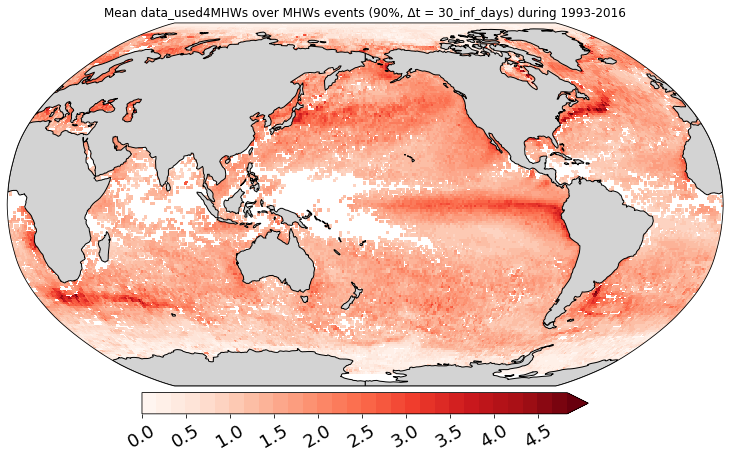

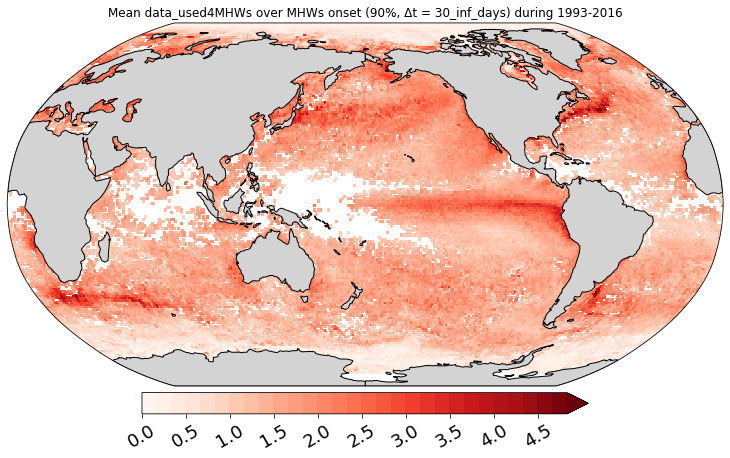

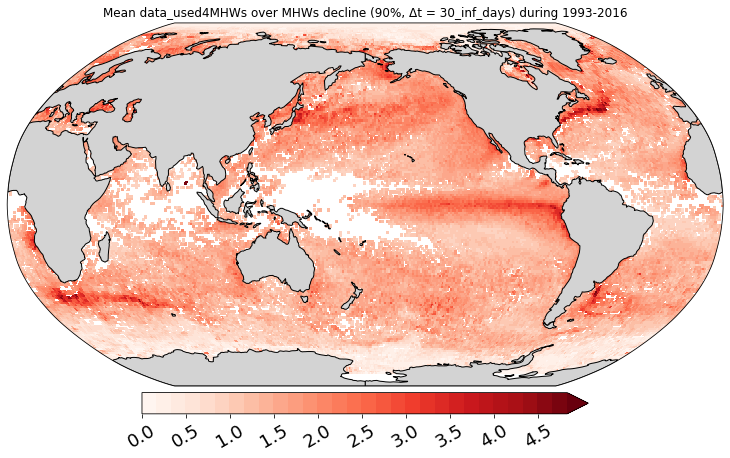

daily duration divided by 30


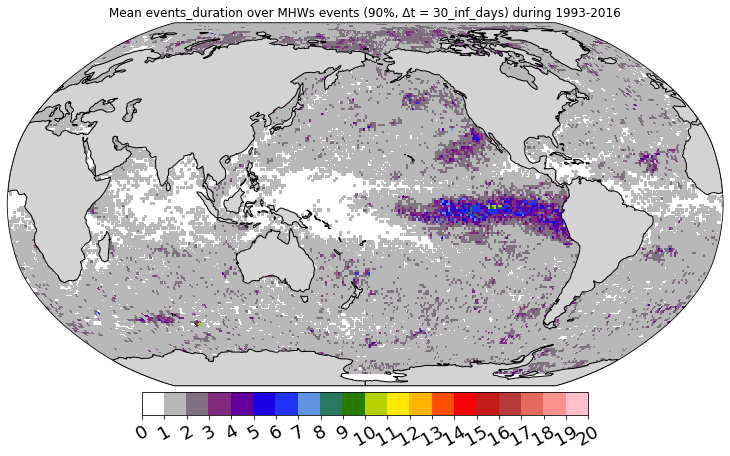

daily duration divided by 30


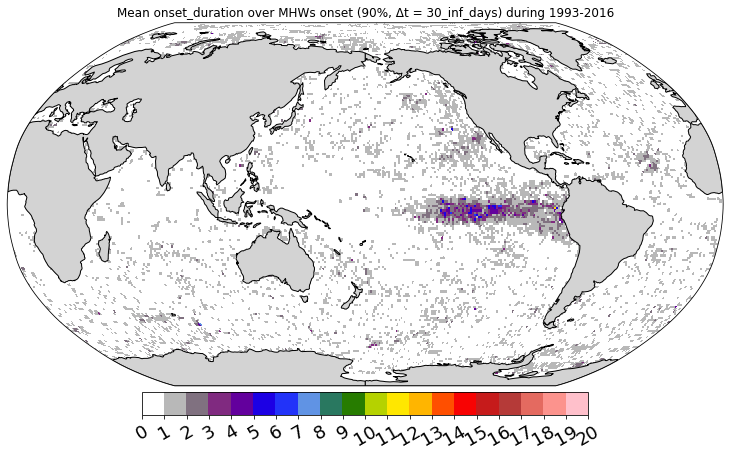

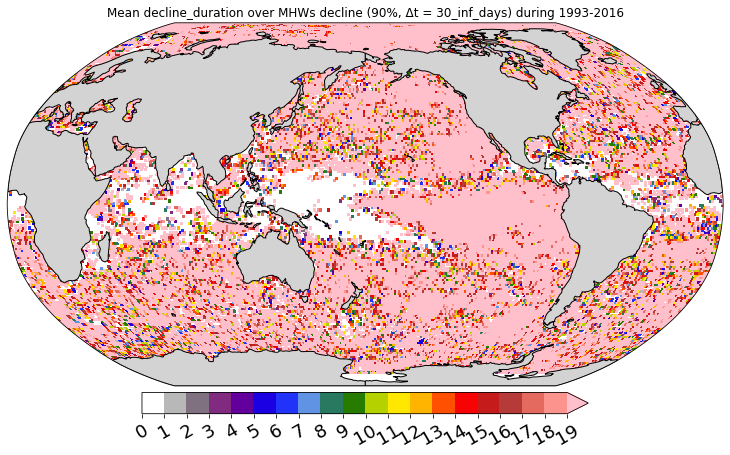

KeyboardInterrupt: 

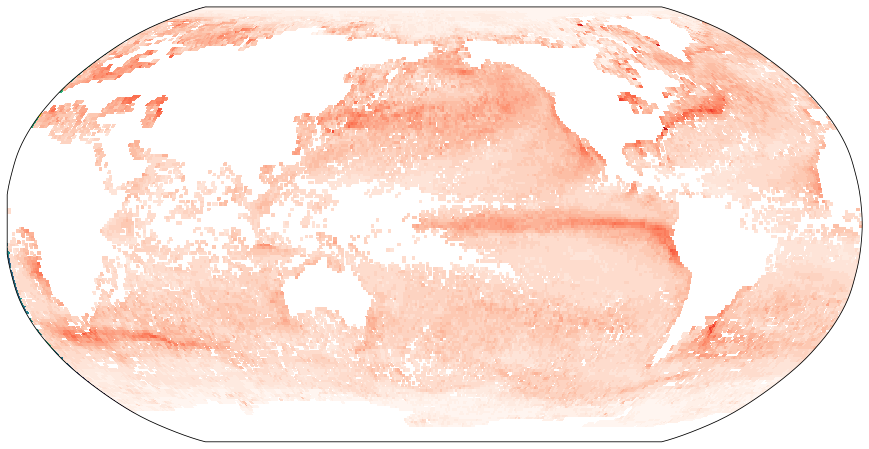

In [22]:
# Loop over the keys and load the variables
for key in keys_list:
    # check if the key is in the list created from the .mat file
    if key in list(find_mhws_info_data.keys()):
        data_bfr_sel = find_mhws_info_data[key].value
        # for ecco ohc k0k5 daily data, multiply for co0 and rho0 to have the correct numbers for ohc
        if 'data' in key and dataset_tag == 'ECCOv4r4_heat' and lev_or_int == 'ohc_k0_k5' and daily_monthly_plot_tag == 'daily':
            data_bfr_sel = find_mhws_info_data[key].value*3989.244*1030
        # for duration daily 30+, divide by 30 so that the colorbar is the same as for monthly
        if 'duration' in key and MHW_duration_min_threshold == 30 and daily_monthly_plot_tag == 'daily' and year_start_4plot ==1993:
            data_bfr_sel = find_mhws_info_data[key].value/30
            print('daily duration divided by 30')

            
    else: # for the cases not included in the list created from the .mat file (like decline_duration_in_tsteps)
        data_bfr_sel = eval(key) 
  
    # Skip filtering based on min/max duration of MHW for monthly case    
    if ecco_monthly_tag or dataset_tag == 'argo_ohc15_50' or (dataset_tag == 'oisst_v2' and daily_monthly_plot_tag == 'monthly'):
        data_bfr_sel = data_bfr_sel
    # Filter based on min/max duration of MHW
    # Note: decline_duration_in_tsteps is based on the 'regular' indexing, so different from all the other decline variables
    else:
        if ('decline' in key) & (key != 'decline_duration_in_tsteps'):# & (dataset_tag != 'oisst_v2'):
            condition_min = events_duration_in_tsteps_at_peak < MHW_duration_max_threshold        
            condition_max = events_duration_in_tsteps_at_peak > MHW_duration_min_threshold  
        else:
            condition_min = find_mhws_info_data['events_duration_in_tsteps'].value < MHW_duration_max_threshold
            condition_max = find_mhws_info_data['events_duration_in_tsteps'].value > MHW_duration_min_threshold
        data_bfr_sel[~(condition_min & condition_max)] = np.nan
    # Make composite maps
    for operation in operations:
        
        # Filter time
        data_bfr_sel_sliced = data_bfr_sel[eval(ind_time_start_slice):eval(ind_time_end_slice), :, :]
        
        data2plot = calculate_data2plot(data_values = data_bfr_sel_sliced, operation = operation)
        stat_tag = operation.capitalize() # capital letter as the title of the plot starts with it
        
        if grid_and_save_fields_2plot:
            bfr_grid = create_gridded_from_scattered(XC_lon = XC_lon, YC_lat = YC_lat, d2plot = data2plot, dataset_tag = dataset_tag)
            np.save(gridded_path + f'{key}_gridded_{tag_2save_file_4plots}.npy', bfr_grid)
            
        else:
            stat_tag
        
        bfr_grid_loaded = np.load(gridded_path + f'{key}_gridded_{tag_2save_file_4plots}.npy', allow_pickle=True)
        
        plot_map_from_gridded(grid_x=bfr_grid_loaded[0], grid_y=bfr_grid_loaded[1], grid_z0=bfr_grid_loaded[2], keyplot=key, \
                      year_start=year_start_4plot, year_end=year_end_4plot, save_path=save_path, \
                      stat_tag=stat_tag, dataset_tag=dataset_tag, lev_or_int=lev_or_int, \
                      MHW_duration_threshold_tag=MHW_duration_threshold_tag, delta_time_tag=delta_time_tag, \
                      test_peaks_tag=test_peaks_tag, ecco_monthly_tag_field=ecco_monthly_tag_field, \
                      daily_monthly_plot_tag=daily_monthly_plot_tag)


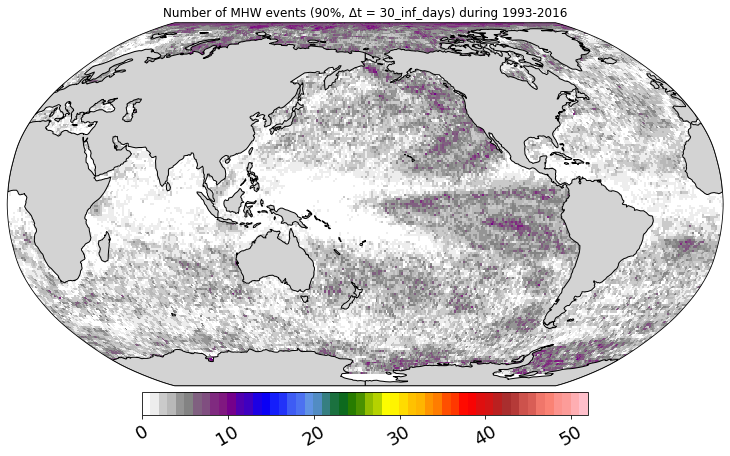

In [23]:
# Calculate new event number, after masking MHW based on their duration and years
key = 'events_number'
if ecco_monthly_tag or dataset_tag == 'argo_ohc15_50' or (dataset_tag == 'oisst_v2' and daily_monthly_plot_tag == 'monthly'):
    new_events_number = find_mhws_info_data['events_number'].value
    if grid_and_save_fields_2plot:
        bfr_grid = create_gridded_from_scattered(XC_lon = XC_lon, YC_lat = YC_lat, d2plot = new_events_number, dataset_tag = dataset_tag)
        np.save(gridded_path + f'{key}_gridded_{tag_2save_file_4plots}.npy', bfr_grid)
    else:
        stat_tag
    
    bfr_grid_loaded = np.load(gridded_path + f'{key}_gridded_{tag_2save_file_4plots}.npy', allow_pickle=True)
    
else:
    condition_min = find_mhws_info_data['events_duration_in_tsteps'].value < MHW_duration_max_threshold
    condition_max = find_mhws_info_data['events_duration_in_tsteps'].value > MHW_duration_min_threshold
    # Filter based on MHW duration
    data_bfr_for_filter = find_mhws_info_data['events_duration_in_tsteps'].value
    data_bfr_for_filter[~(condition_min & condition_max)] = np.nan
    # Filter based on time
    data_bfr_for_filter = data_bfr_for_filter[eval(ind_time_start_slice):eval(ind_time_end_slice), :, :]
    # Calculate new event number
    new_events_number = np.sum(~np.isnan(data_bfr_for_filter), axis=0)
    
    stat_tag = ''
    
    if grid_and_save_fields_2plot:
        bfr_grid = create_gridded_from_scattered(XC_lon = XC_lon, YC_lat = YC_lat, d2plot = new_events_number, dataset_tag = dataset_tag)
        np.save(gridded_path + f'{key}_gridded_{tag_2save_file_4plots}.npy', bfr_grid)
    else:
        stat_tag
    
    bfr_grid_loaded = np.load(gridded_path + f'{key}_gridded_{tag_2save_file_4plots}.npy', allow_pickle=True)

# Event number plot 
plot_map_from_gridded(bfr_grid_loaded[0], bfr_grid_loaded[1], bfr_grid_loaded[2], key, year_start_4plot, year_end_4plot, save_path, stat_tag,
                                dataset_tag, lev_or_int, MHW_duration_threshold_tag, 
                                delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, daily_monthly_plot_tag)


In [ ]:
ciao

# Positive / negative plots

In [ ]:
if dataset_tag == 'ECCOv4r4_heat':
    # Define the terms to iterate over
    if daily_monthly_plot_tag == 'monthly':
        terms = ['forcing', 'advection_conv', 'diffusion_conv']
    else:
        terms = ['forcing', 'advection', 'diffusion']

    # Define the phases to iterate over
    phases = ['onset', 'decline']

    # Iterate over phases and terms
    for phase in phases:
        for term in terms:
            map_contributor_positive_negative(find_mhws_info_data, 
                                              XC_lon, YC_lat, 
                                              phase, term, save_path, 
                                              daily_monthly_plot_tag, 
                                              MHW_duration_min_threshold, 
                                              MHW_duration_max_threshold, 
                                              0 if phase == 'onset' else events_duration_in_tsteps_at_peak, 
                                              year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, 
                                              MHW_duration_threshold_tag, delta_time_tag, 
                                              test_peaks_tag, ecco_monthly_tag_field,
                                              eval(ind_time_start_slice), eval(ind_time_end_slice))


# Contributor plots

### 1st contributor

In [ ]:
if dataset_tag == 'ECCOv4r4_heat':
    # Percentage of times a given term is positive/negative and dominant
    # title of the plots for the dominant: 1st_contributor
    if daily_monthly_plot_tag == 'monthly':
        # ONSET
        # G_forcing
        forcing1_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_onsetAve', 'G_diffusion_conv_onsetAve', 'G_advection_conv_onsetAve', np.greater, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection1_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_conv_onsetAve', 'G_diffusion_conv_onsetAve', 'G_forcing_onsetAve', np.greater, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion1_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_conv_onsetAve', 'G_advection_conv_onsetAve', 'G_forcing_onsetAve', np.greater, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))

        # DECLINE
        # G_forcing
        forcing1_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_declineAve', 'G_diffusion_conv_declineAve', 'G_advection_conv_declineAve', np.less, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection1_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_conv_declineAve', 'G_diffusion_conv_declineAve', 'G_forcing_declineAve', np.less, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion1_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_conv_declineAve', 'G_advection_conv_declineAve', 'G_forcing_declineAve', np.less, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
    else:
        # ONSET
        # G_forcing
        forcing1_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_onsetAve', 'G_diffusion_onsetAve', 'G_advection_onsetAve', np.greater, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection1_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_onsetAve', 'G_diffusion_onsetAve', 'G_forcing_onsetAve', np.greater, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion1_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_onsetAve', 'G_advection_onsetAve', 'G_forcing_onsetAve', np.greater, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))

        # DECLINE
        # G_forcing
        forcing1_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_declineAve', 'G_diffusion_declineAve', 'G_advection_declineAve', np.less, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection1_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_declineAve', 'G_diffusion_declineAve', 'G_forcing_declineAve', np.less, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion1_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_declineAve', 'G_advection_declineAve', 'G_forcing_declineAve', np.less, '1st_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))


### 3rd contributor

In [ ]:
if dataset_tag == 'ECCOv4r4_heat':
    # Percentage of times a given term is positive/negative and the least dominant
    # title of the plots for the less dominant: 3rd_contributor
    if daily_monthly_plot_tag == 'monthly':
        # ONSET
        # G_forcing
        forcing3_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_onsetAve', 'G_diffusion_conv_onsetAve', 'G_advection_conv_onsetAve', np.less, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection3_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_conv_onsetAve', 'G_diffusion_conv_onsetAve', 'G_forcing_onsetAve', np.less, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion3_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_conv_onsetAve', 'G_advection_conv_onsetAve', 'G_forcing_onsetAve', np.less, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))

        # DECLINE
        # G_forcing
        forcing3_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_declineAve', 'G_diffusion_conv_declineAve', 'G_advection_conv_declineAve', np.greater, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection3_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_conv_declineAve', 'G_diffusion_conv_declineAve', 'G_forcing_declineAve', np.greater, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion3_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_conv_declineAve', 'G_advection_conv_declineAve', 'G_forcing_declineAve', np.greater, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
    else:
        # ONSET
        # G_forcing
        forcing3_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_onsetAve', 'G_diffusion_onsetAve', 'G_advection_onsetAve', np.less, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection3_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_onsetAve', 'G_diffusion_onsetAve', 'G_forcing_onsetAve', np.less, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion3_onset = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_onsetAve', 'G_advection_onsetAve', 'G_forcing_onsetAve', np.less, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))

        # DECLINE
        # G_forcing
        forcing3_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_forcing_declineAve', 'G_diffusion_declineAve', 'G_advection_declineAve', np.greater, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection3_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_advection_declineAve', 'G_diffusion_declineAve', 'G_forcing_declineAve', np.greater, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion3_decline = map_first_or_third_contributor(find_mhws_info_data, 'G_diffusion_declineAve', 'G_advection_declineAve', 'G_forcing_declineAve', np.greater, '3rd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))


### 2nd contributor

In [ ]:
if dataset_tag == 'ECCOv4r4_heat':
    # Percentage of times a given term is positive/negative and the 2nd dominant
    if daily_monthly_plot_tag == 'monthly':
        # ONSET
        # G_forcing
        forcing2_onset = map_second_contributor(find_mhws_info_data, 'G_forcing_onsetAve', 'G_diffusion_conv_onsetAve', 'G_advection_conv_onsetAve', np.greater, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection2_onset = map_second_contributor(find_mhws_info_data, 'G_advection_conv_onsetAve', 'G_diffusion_conv_onsetAve', 'G_forcing_onsetAve', np.greater, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion2_onset = map_second_contributor(find_mhws_info_data, 'G_diffusion_conv_onsetAve', 'G_advection_conv_onsetAve', 'G_forcing_onsetAve', np.greater, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))

        # DECLINE
        # G_forcing
        forcing2_decline = map_second_contributor(find_mhws_info_data, 'G_forcing_declineAve', 'G_diffusion_conv_declineAve', 'G_advection_conv_declineAve', np.less, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection2_decline = map_second_contributor(find_mhws_info_data, 'G_advection_conv_declineAve', 'G_diffusion_conv_declineAve', 'G_forcing_declineAve', np.less, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion2_decline = map_second_contributor(find_mhws_info_data, 'G_diffusion_conv_declineAve', 'G_advection_conv_declineAve', 'G_forcing_declineAve', np.less, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
    else:
        # ONSET
        # G_forcing
        forcing2_onset = map_second_contributor(find_mhws_info_data, 'G_forcing_onsetAve', 'G_diffusion_onsetAve', 'G_advection_onsetAve', np.greater, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection2_onset = map_second_contributor(find_mhws_info_data, 'G_advection_onsetAve', 'G_diffusion_onsetAve', 'G_forcing_onsetAve', np.greater, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion2_onset = map_second_contributor(find_mhws_info_data, 'G_diffusion_onsetAve', 'G_advection_onsetAve', 'G_forcing_onsetAve', np.greater, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak = 0, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))

        # DECLINE
        # G_forcing
        forcing2_decline = map_second_contributor(find_mhws_info_data, 'G_forcing_declineAve', 'G_diffusion_declineAve', 'G_advection_declineAve', np.less, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_advection
        advection2_decline = map_second_contributor(find_mhws_info_data, 'G_advection_declineAve', 'G_diffusion_declineAve', 'G_forcing_declineAve', np.less, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))
        # G_diffusion
        diffusion2_decline = map_second_contributor(find_mhws_info_data, 'G_diffusion_declineAve', 'G_advection_declineAve', 'G_forcing_declineAve', np.less, '2nd_contributor', new_events_number, daily_monthly_plot_tag, MHW_duration_min_threshold, MHW_duration_max_threshold, year_start_4plot, year_end_4plot, dataset_tag, lev_or_int, MHW_duration_threshold_tag, delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, events_duration_in_tsteps_at_peak, XC_lon = XC_lon, YC_lat = YC_lat, save_path = save_path, stat_tag = stat_tag, time_start_slice = eval(ind_time_start_slice), time_end_slice = eval(ind_time_end_slice))


### Plots to show difference between onset and decline

In [ ]:
if dataset_tag == 'ECCOv4r4_heat':
    stat_tag = 'Mean_difference_onset_MINUS_decline'
    keys_list_diff = ['G_advection', 'G_diffusion', 'G_total', 'G_forcing', 'data_used4MHWs', 'duration_in_tsteps']


In [ ]:
if dataset_tag == 'ECCOv4r4_heat':
    for key in keys_list_diff:
        # Filter based on min/max duration of MHW
        condition_min_decline = events_duration_in_tsteps_at_peak < MHW_duration_max_threshold        
        condition_max_decline = events_duration_in_tsteps_at_peak > MHW_duration_min_threshold  
        condition_min_onset = find_mhws_info_data['events_duration_in_tsteps'].value < MHW_duration_max_threshold
        condition_max_onset = find_mhws_info_data['events_duration_in_tsteps'].value > MHW_duration_min_threshold
        if key != 'duration_in_tsteps':       
            data_onset = find_mhws_info_data[f'{key}_onsetAve'].value
            data_decline = find_mhws_info_data[f'{key}_declineAve'].value
            data_decline[~(condition_min_decline & condition_max_decline)] = np.nan     
        else:
            data_onset = find_mhws_info_data[f'onset_{key}'].value
            data_decline = decline_duration_in_tsteps
            data_decline[~(condition_min_onset & condition_max_onset)] = np.nan # duration_in_tsteps has the onset indexes!  
        data_onset[~(condition_min_onset & condition_max_onset)] = np.nan

        # Plot of the differences data onset MINUS data decline
        for operation in operations:
            # Filter time
            data_onset = data_onset[eval(ind_time_start_slice):eval(ind_time_end_slice), :, :]
            data_decline = data_decline[eval(ind_time_start_slice):eval(ind_time_end_slice), :, :]

            data2plot = calculate_data2plot(data_values = data_onset, operation = operation) - calculate_data2plot(data_values = data_decline, operation = operation)

            if grid_and_save_fields_2plot:
                bfr_grid = create_gridded_from_scattered(XC_lon = XC_lon, YC_lat = YC_lat, d2plot = data2plot, dataset_tag = dataset_tag)
                np.save(gridded_path + f'{key}_DIFFERENCES_gridded_{tag_2save_file_4plots}.npy', bfr_grid)
            else:
                stat_tag

            bfr_grid_loaded = np.load(gridded_path + f'{key}_DIFFERENCES_gridded_{tag_2save_file_4plots}.npy', allow_pickle=True)        

            plot_map_from_gridded(bfr_grid_loaded[0], bfr_grid_loaded[1], bfr_grid_loaded[2], key, year_start_4plot, year_end_4plot, save_path, stat_tag,
                                    dataset_tag, lev_or_int, MHW_duration_threshold_tag, 
                                    delta_time_tag, test_peaks_tag, ecco_monthly_tag_field, daily_monthly_plot_tag)


In [ ]:
ciao

### TESTS

In [ ]:
# tot1_onset = forcing1_onset + advection1_onset + diffusion1_onset
# tot3_onset = forcing3_onset + advection3_onset + diffusion3_onset
# tot2_onset = forcing2_onset + advection2_onset + diffusion2_onset

# tot1_decline = forcing1_decline + advection1_decline + diffusion1_decline
# tot3_decline = forcing3_decline + advection3_decline + diffusion3_decline
# tot2_decline = forcing2_decline + advection2_decline + diffusion2_decline


In [ ]:
# TEST TO CHECK THAT THE MASK WORKED
# data_bfr_sel.condition = find_mhws_info_data['events_duration_in_tsteps'].value >= 23
# condition
# mask_non_nan = ~np.isnan(data_bfr_sel)
# mask_non_nan

# import numpy as np

# # Assuming bool_array1 and bool_array2 are your boolean arrays
# differences = np.where(condition != mask_non_nan)

# if len(differences[0]) == 0:
#     print("The boolean arrays are the same.")
# else:
#     print("The boolean arrays are different at the following indices:")
#     print(differences)

# are_masks_equal = np.array_equal(condition, mask_non_nan)

# if are_masks_equal:
#     print("The masks are the same.")
# else:
#     print("The masks are different.")

In [ ]:
# OSM2024

# Define the colors for positive values (yellow to red)
positive_colors = ['#FFFF00', '#FFA500', '#FF0000']

# Define the colors for negative values (green to purple)
negative_colors = ['#008000', '#0000FF', '#800080']

# Define the color for zero (white)
zero_color = 'white'

# Create a list of colors for the colormap
colors = negative_colors[::-1] + [zero_color] + positive_colors

# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Maps for all variables (mean, median, max, and min)
    
keys_list = ['G_forcing_onsetAve', 'G_forcing_declineAve']
keys_list = ['G_advection_onsetAve', 'G_advection_declineAve', 'G_diffusion_onsetAve', 'G_diffusion_declineAve']

# Loop over the keys and load the variables
for key in keys_list:
    # check if the key is in the list created from the .mat file
    if key in list(find_mhws_info_data.keys()):
        data_bfr = find_mhws_info_data[key].value
    else: # for the cases not included in the list created from the .mat file (like decline_duration_in_tsteps)
        data_bfr = eval(key)  
    # if statement for the cases that do not require operation
    if len(data_bfr.shape) == 2: # for this one, don't use the operations in the list above
        stat_tag = ''
        plot_map_from_scattered(XC_lon, YC_lat, data_bfr, key, year_start, year_end, save_path, stat_tag)
    elif len(data_bfr.shape) == 3:
        for operation in operations:
            data2plot = calculate_data2plot(data_values = data_bfr, operation = operation)
            stat_tag = operation.capitalize() # capital letter as the title of the plot starts with it
            plot_map_from_scattered(XC_lon, YC_lat, data2plot, key, year_start, year_end, save_path, stat_tag)
